In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import astropy
from astropy.io import fits
from astropy.io import ascii

from astropy.table import Table
from astropy.timeseries import TimeSeries
from astropy.time import Time
from astropy.timeseries import TimeSeries, aggregate_downsample
from astropy.coordinates import match_coordinates_sky as coords

from PIL import Image

import warnings
warnings.filterwarnings('ignore')

from mid_IR_variables import fileIO_processing as fp
from mid_IR_variables import lightcurve_processing as lp
from mid_IR_variables import ZTF_lightcurve_processing as zlp
from mid_IR_variables import reverberation_mapper 
from mid_IR_variables import MCMC_sampler


from sklearn.gaussian_process import GaussianProcessRegressor, kernels

from scipy import optimize
import scipy.stats as stats

import os

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 22})
matplotlib.rc('font',**{'family':'serif','serif':['Times']})
matplotlib.rc('text', usetex=True)

SAVE_FILEPATH = 'C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'
IMPORT_FILEPATH ='C:/Users/paiaa/Documents/Research/Blanton Lab/Midir Variables/'

mnsa_hdu, manga_wise_hdu, pipe3d_hdu = fp.import_manga(6, 1, 1)
mnsa, mwv, pipe3d = mnsa_hdu.data, manga_wise_hdu.data, pipe3d_hdu.data

tab = Table.read('reverb_lags_run3.txt', format='ascii.ipac')

In [3]:
def generate_javelin_data():
    pifus = tab['plateifu']

    for pifu in pifus:
        os.makedirs(SAVE_FILEPATH+"Data/JAVELIN/"+pifu, exist_ok=True)

        opt_data = lp.generate_combined_lightcurve(pifu)
        a, b, c, d = fp.bin_data(opt_data, 10, 1000)
        b = b[~b['mag'].mask]

        opt_data=Table()
        opt_data['time'] = (b['time_bin_start'].to_value('decimalyear') - b['time_bin_start'][0].to_value('decimalyear'))*365.2422
        opt_data['mag'] = b['mag']
        opt_data['mag_err'] = b['mag_err']
        opt_data.write(SAVE_FILEPATH+"Data/JAVELIN/"+pifu+"/optical.dat", format='ascii.no_header', overwrite=True)

        w1 = fp.process_wise(pifu, mwv, band=1)
        w1['time'] = (w1['time'].to_value('decimalyear')- b['time_bin_start'][0].to_value('decimalyear'))*365.2422
        #w1_size = np.size(w1)
        w1.write(SAVE_FILEPATH+"Data/JAVELIN/"+pifu+"/w1.dat", format='ascii.no_header', overwrite=True)

        w2 = fp.process_wise(pifu, mwv, band=2)
        w2['time'] = (w2['time'].to_value('decimalyear')- b['time_bin_start'][0].to_value('decimalyear'))*365.2422
        #w2_size = np.size(w2)
        w2.write(SAVE_FILEPATH+"Data/JAVELIN/"+pifu+"/w2.dat", format='ascii.no_header', overwrite=True)

In [4]:
def generate_optical_lightcurve(pifu, l=[0.95, 1.05]):

        optical_lightcurve = lp.generate_combined_lightcurve(pifu)

        poly_subtracted_obj_p, fit, fitted_poly = lp.polyfit_lightcurves(optical_lightcurve, deg=10)
        gp, llh, hyperparams, cov = lp.GP(poly_subtracted_obj_p, kernel_num=3, lengthscale=(l[0], l[1]))
        gp_fitted_poly =lp.make_polynomial(gp, fit)
        
        gp['mag']+=gp_fitted_poly
        print('**GP Kernel:', str(hyperparams)+'**')

        return optical_lightcurve, gp

In [13]:
javelin_w1, javelin_w2 = np.array([]), np.array([])
jav_errw1_max, jav_errw1_min = np.array([]), np.array([])
jav_errw2_max, jav_errw2_min = np.array([]), np.array([])
for pifu in tab['plateifu']:
##log(sigma), log(tau), time_lag, width, amp
    javelin_results = Table.read(IMPORT_FILEPATH+'Data/JAVELIN/'+pifu+'/javelin_results.txt', format='ascii.ipac')
    javelin_w1 = np.append(javelin_w1, javelin_results[2]['w1hpd_med'])
    jav_errw1_max = np.append(jav_errw1_max, javelin_results[2]['w1hpd_high'])
    jav_errw1_min = np.append(jav_errw1_min, javelin_results[2]['w1hpd_low'])

    javelin_w2 = np.append(javelin_w2, javelin_results[2]['w2hpd_med'])
    jav_errw2_max = np.append(jav_errw2_max, javelin_results[2]['w2hpd_high'])
    jav_errw2_min = np.append(jav_errw2_min, javelin_results[2]['w2hpd_low'])

In [14]:
tab['jav_lag_w1'] = javelin_w1
tab['jav_lag_w2'] = javelin_w2

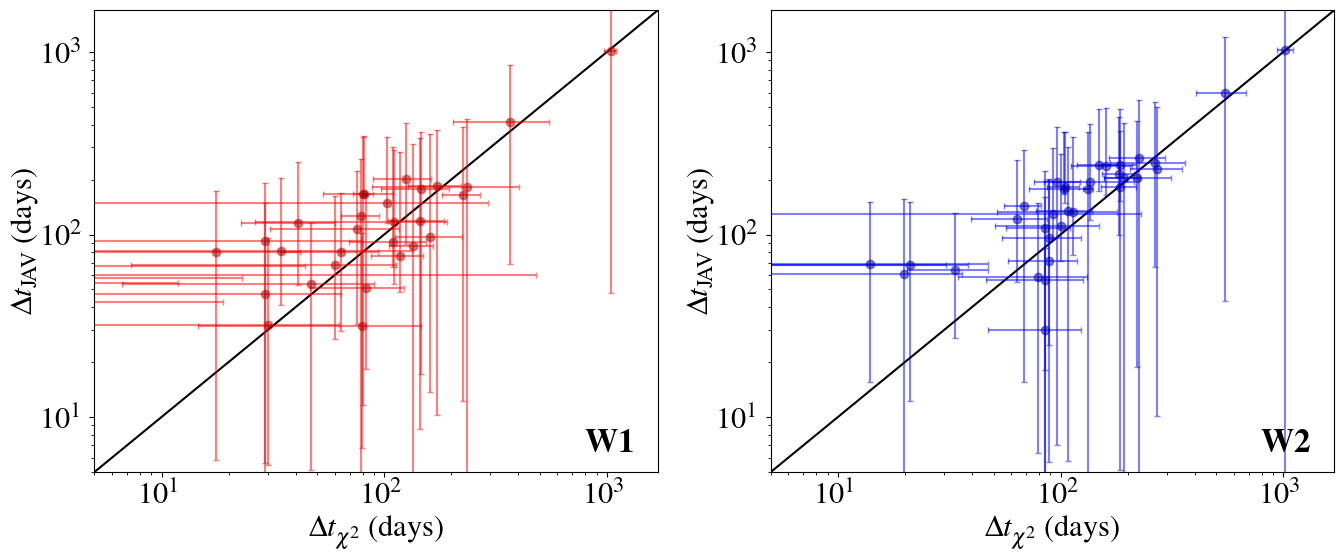

In [46]:
x = np.linspace(0, 4)
fig, ax = plt.subplots(figsize=(16,6), ncols=2)

ax[0].errorbar(tab['lag_w1'], tab['jav_lag_w1'], yerr=( jav_errw1_min, jav_errw1_max), xerr=(tab['lag_w1_yerr_min'], tab['lag_w1_yerr_max']), 
               ls='none', c='r', mfc='maroon', marker='o', capsize=2, alpha=0.5)
ax[0].plot(10**x, 10**x, c='k', zorder=-1)
ax[0].text(0.87, 0.03, r'\textbf{W1}', fontsize=24, ha='left', va='bottom', transform=ax[0].transAxes)


ax[0].set_ylim(5, 1700)
ax[0].set_xlim(5, 1700)

ax[0].set_ylabel(r'$\Delta t_{\rm JAV}$ (days)')
ax[0].set_xlabel(r'$\Delta t_{\chi^2}$ (days)')

ax[0].set_yscale('log')
ax[0].set_xscale('log')



ax[1].errorbar(tab['lag_w2'], tab['jav_lag_w2'], yerr=( jav_errw2_min, jav_errw2_max), xerr=(tab['lag_w2_yerr_min'], tab['lag_w2_yerr_max']), 
               ls='none', c='b', mfc='navy', marker='o', capsize=2, alpha=0.5)
ax[1].plot(10**x, 10**x, c='k', zorder=-1)
ax[1].text(0.87, 0.03, r'\textbf{W2}', fontsize=24, ha='left', va='bottom', transform=ax[1].transAxes)

ax[1].set_ylim(5, 1700)
ax[1].set_xlim(5, 1700)

ax[1].set_ylabel(r'$\Delta t_{\rm JAV}$ (days)')
ax[1].set_xlabel(r'$\Delta t_{\chi^2}$ (days)')

ax[1].set_yscale('log')
ax[1].set_xscale('log')